### Ultimate Data Science Challenge

Data:
- logins.json
- ultimate_data_challenge.json

### Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

#### Answer:
    - The time-series data is non-stationary (Based on histogram plot of the login counts, ADF test, and time-series 
      decomposition)
    - The data shows weekly cycles.
    
See below for detailed analysis    

A. logins Dataset

1.1. Load data, convert to datetime, and resample to 15 min intervals

In [1]:
import pandas as pd

df1=pd.read_json('logins.json')
#change to datetime
df1=pd.to_datetime(df1['login_time'])
df1=pd.DataFrame(df1) #change to a DataFrame 

df1['Counts']=1 #crete a new column
df1.head() #check


,login_time,Counts
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [2]:
#resample data in 15 min increments
#https://stackoverflow.com/questions/14861023/resampling-minute-data

df1=df1.set_index('login_time') 
df1=df1.resample('15Min').sum()
df1.head() #check

,Counts
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [3]:
df1.isnull().sum() #count number of null entries.

Counts    407
dtype: int64

In [4]:
#set null entries to zero
df1=df1.fillna(0) #fill na entries with 0
df1.isnull().sum() #check

Counts    0
dtype: int64

1.2. Visualize data

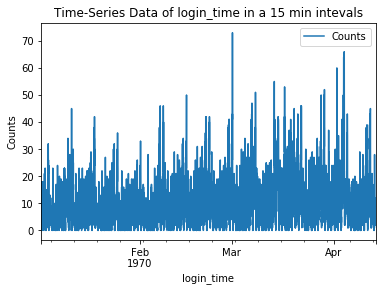

In [5]:
import matplotlib.pyplot as plt

df1.plot()
plt.ylabel('Counts')
plt.title('Time-Series Data of login_time in a 15 min intevals')
plt.show()

In [6]:
#resample into daily intervals
df1=df1.resample('D').sum()
df1.isnull().sum() #check

Counts    0
dtype: int64

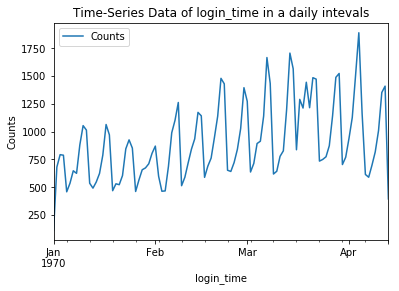

In [7]:
df1.plot()
plt.ylabel('Counts')
plt.title('Time-Series Data of login_time in a daily intevals')
plt.show()

- The above time-series data shows the number of logins over per 15 min interval and per day
- Overall, the time series data looks cyclical    
- There is an obvious anomaly in the cyclical pattern during the 3rd week of March  
- The amplitude is generally lower in the beginning, and it increases with time

1.3. Determine if the time-series data is stationary or not

A. Visual inspection

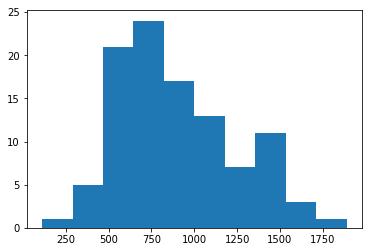

In [8]:
#df1.Counts.plot(kind='hist')

plt.hist(df1.Counts)
plt.show()


- The histogram plot of the data shows that the distribution is slightly skewed to the right. This suggests that the time-series data is non-stationary. 

B. Perform an augmented Dickey-Fuller test

H0: time-series data is non-stationary  
H1: time series data is stationary

In [9]:
from statsmodels.tsa.stattools import adfuller

print('ADF Statistic: %.2f' %(adfuller(df1.Counts.values)[0]))
print('p-value: %.2f' %(adfuller(df1.Counts.values)[1]))

print('Critical values:')
for key,value in adfuller(df1.Counts.values)[4].items():
    print('\t%s: %.3f' %(key,value))

ADF Statistic: -1.40
p-value: 0.58
Critical values:
	10%: -2.584
	1%: -3.506
	5%: -2.895


- Since the test statistic is greater than the critical values, we fail to reject the null hypothesis.This means that the time-series data is non-stationary (i.e., the trend changes with time)

C. Time-series decomposition

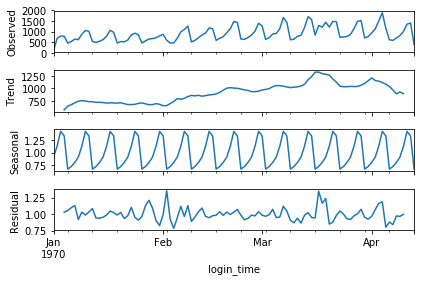

In [10]:
#decompose time-series data
#ref.: Jason Brownlee, "Introduction to Time Series Forecasting with Python", Machine Learning Mastery, pg.123
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(df1.Counts,model='multiplicative')
result.plot()
plt.show()

- The trend is non-linear
- The seasonal component is cyclical 
- The residual shows periods of high variability in early Feb. and in mid-Mar

D. Characterize Counts

### Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

#### 2.1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

If the experiment is successful: 
    - (1) more cars will pass through the toll road 
    - (2) the proportion of cars from each city will change in both cities.  

The change in the proportion of cars from each city in both cities will be a good key measure of success. This is a direct indicator of whether the driver partners remain exclusive to each city or not after the toll costs reimbursement program is introduced.

##### 2.2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
#### a. how you will implement the experiment  
A practical way to implement the experiment is to give each driver a membership card which can be used to admit the driver into the toll road free of charge. Each time the driver enter the toll road, the card is scanned and the entry is recorded. The driver's city of origin is noted. This is a more efficient approach than having the driver to reimburst payments.

#### b. what statistical test(s) you will conduct to verify the significance of the observation  
I will perform a paired/dependent t-test. I will compare the number of cars passing through the toll roads, as well as the proportion of drivers from each city before and after the toll costs reimbursement program is introduced.

#### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.  
I will choose an alpha value of 5%. The null hypothesis would state that the mean difference in the average number of cars passing through the toll roads before and after the program is introduced is zero. The alternative hypothesis would state that the mean difference is greater than zero.


### Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

#### 3.1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

#### Answer:

- The fraction of observed users that were retained is: 0.6922

See below for detailed analysis

A. Import and inspect data

In [ ]:
#https://stackoverflow.com/questions/36837663/reading-json-file-as-pandas-dataframe-error
import pandas as pd
import json

#import as json
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

#convert into pandas
df2=pd.DataFrame(data)
df2.head()

In [ ]:
#change date fields to datetime
df2['signup_date']=pd.to_datetime(df2['signup_date'])
max(df2['signup_date']) #check

In [ ]:
#inspect data
df2.info()

- There are missing data for: 
    - avg_rating_by_driver
    - avg_rating_of_driver
    - phone

In [ ]:
#check the number of cities

set(df2.city) 

In [ ]:
#do counts of number of entries per city

df2.city.value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.show()

- There are three cities

B. Add an additional column to indicate if the user is active or not

In [ ]:

df2['Active_or_not']=df2.trips_in_first_30_days>0
df2.head() #check


In [ ]:
#fraction of observed users that were retained:

#check if there are nulls
df2.Active_or_not.isnull().sum()
#there are no null values

- Since there are no missing values, data treatment is not needed.

In [ ]:
#fraction of observed users that were retained:

fract_ret=df2[df2.Active_or_not==True]['Active_or_not'].value_counts().sum()/df2.Active_or_not.value_counts().sum()
print('The fraction of observed users that were retained is: %s' %(fract_ret))

#### 3.2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

#### Answer:

- Relevant fields are selected for the model: 
    - avg_rating_by_driver
    - avg_rating_of_driver
    - avg_surge 
    - surge_pct
    - trips_in_first_30_days
    - ultimate_black_user
    - weekday_pct  
<br>    
- A gradient boosting model is selected because: 
    - such an ensemble model will yield a more accurate result than an individual model.
    - gradient boosting does not require the data to be treated (i.e., normalized or standardized. This makes the 
    interpretation straightforward.   
<br>    
- The model yields a 0.99 accuracy both for the training and test datasets. Moreover, the AUC ROC is 0.99. This means that the fraction of true positives much exceed the fraction of the false positives.  
<br>  
- See below for detailed analysis.

A. Prepare and Review Data

In [ ]:
#create a new column to show the length of time the user has been a user.
#calculate the time-delta between signup_date and last_trip_date
#https://stackoverflow.com/questions/22923775/calculate-pandas-dataframe-time-difference-between-two-columns-in-hours-and-minu

df2['length_of_service']=(pd.to_datetime(df2.last_trip_date) - pd.to_datetime(df2.signup_date))
df2.head() #check

In [ ]:
#add a new column to indicate if user has signed up for at least 5 months.
df2['at_least_5_months']=df2.length_of_service.dt.days > 150
df2[df2['at_least_5_months']==True] #check
df2.head() #check

In [ ]:
#only keep users that have signed up for at least 5 months

df_signed_up_at_least_5_mths=df2[df2.at_least_5_months==True]
df_signed_up_at_least_5_mths #check

In [ ]:
#count number of users wo got into the sixth month
df_signed_up_at_least_5_mths.shape[0]

In [ ]:
#number of users initially

df2.shape[0]

In [ ]:
#fraction of users who have signed up for at least 5 months
12198/50000

- Only 24.4% users have signed up for at least 5 months. 

***

In [ ]:
#select just the data in which the users have signed up for at least 5 months.
#do modeling and see which ones remain active.

In [ ]:
#create a new dataframe with relevant fields.
#change data type as needed 
#plot out the data to visualize

df_signed_up_at_least_5_mths_selected=pd.DataFrame(df2.loc[:,['avg_dist', \
                                                'avg_rating_by_driver', \
                                                'avg_rating_of_driver', \
                                                'avg_surge', \
                                                'surge_pct', \
                                                'trips_in_first_30_days', \
                                                'ultimate_black_user', \
                                                'weekday_pct']])
df_signed_up_at_least_5_mths_selected.head() #check

In [ ]:
plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['avg_dist'].plot(kind='hist', bins=30)
plt.title('avg_dist')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['avg_rating_by_driver'].plot(kind='hist', bins=30)
plt.title('avg_rating_by_driver')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['avg_rating_of_driver'].plot(kind='hist', bins=30)
plt.title('avg_rating_of_driver')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['avg_surge'].plot(kind='hist', bins=30)
plt.title('avg_surge')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['surge_pct'].plot(kind='hist', bins=30)
plt.title('surge_pct')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['trips_in_first_30_days'].plot(kind='hist', bins=30)
plt.title('trips_in_first_30_days')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['ultimate_black_user'].value_counts().plot(kind='bar')
plt.title('ultimate_black_user')

plt.subplots(figsize=(5,3))
df_signed_up_at_least_5_mths_selected['weekday_pct'].plot(kind='hist', bins=30)
plt.title('weekday_pct')
 
            
plt.tight_layout()
plt.show()


- The above charts show that the following fields show skewed distributions:
        - avg_dist: most users travel a short distance
        - avg_rating_by_driver: most drivers are rated highly
        - avg_rating_of_driver: most drivers are rated highly
        - avg_surge: avg_surge are close to 1
        - surge_pct: surge_pct are close to 0 
        - trips_in_first_30_days: the number of trips in the first 30 days are mostly close to 0
        

***

B. Prepare Data for Modeling

In [ ]:
#review data

df2.head()

In [ ]:
#select only relevant columns
df2_selected=df2.loc[:,['avg_dist','avg_rating_by_driver',\
                        'avg_rating_of_driver','avg_surge','city','phone',\
                        'surge_pct','trips_in_first_30_days','ultimate_black_user',\
                       'weekday_pct','at_least_5_months']]

In [ ]:
#check data types
df2_selected.info()

In [ ]:
#convert to the appropriate data types as needed
#first, convert to categorical
df2_selected.city=df2_selected.city.astype('category')
df2_selected.phone=df2_selected.phone.astype('category')

#then, convert to dummy variables
df2_selected=pd.get_dummies(df2_selected, prefix=['city','phone']); #change to dummy variables
df2_selected.info() #check

In [ ]:
#remove null values
df2_selected.dropna(inplace=True)

df2_selected.info() #check

In [ ]:
#set X and Y datasets
X=df2_selected.iloc[:,:-1].values
Y=df2_selected.iloc[:,-1].values

#X #check
#Y #check

In [ ]:
#Apply gradient boosting

# Import machine learning modules
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, partial_dependence
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2,random_state=123)


In [ ]:
gbc=GradientBoostingClassifier()
gbc.fit(X_train,y_train)

In [ ]:
print('Training score: %.2f' %(gbc.score(X_train,y_train)))
print('Test score: %.2f' %(gbc.score(X_test,y_test)))

- Both training and test scores are high at 0.99.

In [ ]:
import seaborn as sns
# Plot feature importances
plt.title('Normalized Feature Importances')
sns.barplot(y=df2_selected.iloc[:,:-1].columns, x=gbc.feature_importances_)
plt.show()

- The above graph shows that the most important feature is phone_Android, followed by avgdist, as well as weekday_pct. 

In [ ]:
# Get class probability predictions on test set
pred = gbc.predict_proba(X_test)

# Only keep the positive class
pred = [p[1] for p in pred]

# Display AUROC
print('Area under the curve: %.2f' %(roc_auc_score(y_test, pred)))


- The area under the curve is close to one. This means that the number of true positives much exceed the number of false positives.

#### 3.3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

#### Answer

- The two major features are:   
    - (1) phone type   
        The model reveals that Android user has the greatest influence on the model, despite that the number of iphone 
        users much exceed the Android user.
        Therefore, I **recommend** to work with the UX team to discuss whether the app features are any different between 
        the two operating systems and whether anything can be improved.
    - (2) avg_dist  
        The avg_distance is a significant feature. A histogram plot of avg_dist shows that the highest distribution os 
        users travel less than 10 miles. I **recommend** the Marketing campaign to focus more on local users (i.e., users who travel a 
        short distance).   
        
        
- See below for additional analysis.


In [ ]:
# (1) check the distribution of phone users
set(df2.phone)

In [ ]:
#plot the distribution of phone types
df2.phone.value_counts().plot(kind='bar')
plt.show()

- It is worth noting that the number of iphone users exceed the number of Android users.

In [ ]:
#(2) avg_dist
df2.avg_dist

df2.avg_dist.hist(bins=50)
plt.show()

- It is worth noting that the highest distribution of avg_dist is less than 10 miles.

#### Data description

● city: city this user signed up in  
● phone: primary device for this user  
● signup_date: date of account registration; in the form ‘YYYY MM DD’  
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’  
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup  
● avg_rating_by_driver: the rider’s average rating over all of their trips  
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips  
● surge_pct: the percent of trips taken with surge multiplier > 1  
● avg_surge: The average surge multiplier over all of this user’s trips  
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up  
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise  
● weekday_pct: the percent of the user’s trips occurring during a weekday  